<a href="https://colab.research.google.com/github/kogen15923/ml-book-3rd-impl/blob/main/ch11/The_base_knowlage_of_NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNISTデータセットの取得と準備

In [1]:
# scikit-learnのfetch_openmlを用いた前処理作業
from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values
# 配列の次元を確認
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [2]:
# 画像データの正規化
# (特徴量スケーリングとは違って中心を0とし(-1, 1)の範囲である)
X = ((X / 255.) - .5) * 2

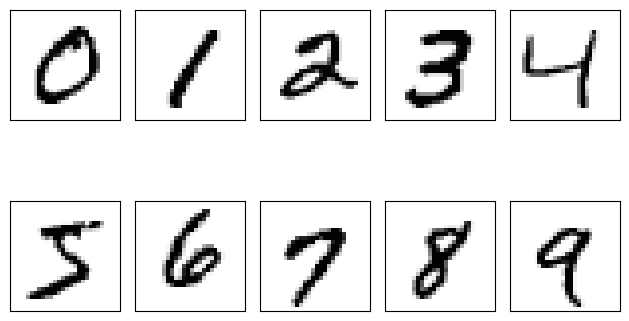

In [3]:
# matplotlibのimshow関数を用いて784ピクセルから28x28の画像を再現
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
  img = X[y ==i][0].reshape(28, 28)
  ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

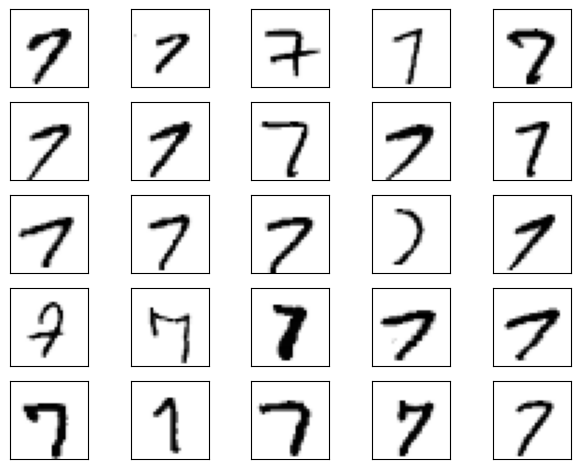

In [4]:
# 同じ数字をいくつか描画して確認する
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
  img = X[y == 7][i].reshape(28, 28)
  ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [5]:
# データセットの分割(訓練サブセット(55000)、検証サブセット(5000)、テストサブセット(10000))
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp
)
# 次元確認
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(55000, 784) (5000, 784) (10000, 784)
(55000,) (5000,) (10000,)


# 多層パーセプトロンの実装

In [6]:
# クラスラベルの整数配列をone-hotエンコーディングのラベルに変換するのとロジスティックシグモイド活性化を計算するヘルパー関数
import numpy as np

def sigmoid(z):
  return 1. / (1. + np.exp(-z))

def int_to_onehot(y, num_labels):
  ary = np.zeros((y.shape[0], num_labels))
  for i, val in enumerate(y):
    ary[i, val] = 1
  return ary

In [7]:
# 多層パーセプトロンのメインクラス
class NeuralNetMLP:
  def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
    super().__init__()
    self.num_classes = num_classes
    # 隠れ層
    rng = np.random.RandomState(random_seed)
    self.weight_h = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_features))
    self.bias_h = np.zeros(num_hidden)
    # 出力層
    self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden))
    self.bias_out = np.zeros(num_classes)

  # 順伝播法
  def forward(self, x):
    # 隠れ層:
    # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
    # out put dim: [n_examples, n_hidden]
    z_h = np.dot(x, self.weight_h.T) + self.bias_h
    a_h = sigmoid(z_h)
    # 出力層:
    # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
    # output dim: [n_examples, n_classes]
    z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
    a_out = sigmoid(z_out)
    return a_h, a_out

  # 誤差逆伝播法
  def backward(self, x, a_h, a_out, y):
    ########################
    ### 出力層の重み
    ########################
    # ont-hot エンコーディング
    y_onehot = int_to_onehot(y, self.num_classes)

    # Part 1: dLoss/dOutWeights = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
    # ここで、DeltaOut = dLoss/dOutAct * dOutAct/dOutNet(再利用に役たつ)

    # input/output dim: [n_examples, n_classes]
    d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

    # input/output dim: [n_examples, n_classes]
    d_a_out__d_z_out = a_out * (1. - a_out)

    # output dim: [n_examples, n_classes]
    delta_out = d_loss__d_a_out * d_a_out__d_z_out

    # 出力層の重みについての勾配

    # [n_examples, n_hidden]
    d_z_out__dw_out = a_h
    # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
    # output dim: [n_classes, n_hiden]
    d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
    d_loss__db_out = np.sum(delta_out, axis=0)

    # Part 2: dLoss/dHiddenWeights = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

    # [n_classes, n_hidden]
    d_z_out__a_h = self.weight_out

    # output dim: [n_examples, n_hidden]
    d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

    # [n_examples, n_hidden]
    d_a_h__d_z_h = a_h * (1. - a_h) # シグモイド関数の微分

    # [n_examples, n_features]
    d_z_h__d_w_h = x

    # output dim: [n_hidden, n_features]
    d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
    d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

    return (d_loss__dw_out, d_loss__db_out, d_loss__d_w_h, d_loss__d_b_h)

In [8]:
# 多層パーセプトロンのインスタンス化

model = NeuralNetMLP(num_features=28*28, num_hidden=50, num_classes=10)

# 便利な訓練関数

In [9]:
# ミニバッチジェネレーター
import numpy as np

num_epochs = 50
minibatch_size = 100

def minibatch_generator(X, y, minibatch_size):
  indices = np.arange(X.shape[0])
  np.random.shuffle(indices)
  for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
    batch_idx = indices[start_idx:start_idx + minibatch_size]
    yield X[batch_idx], y[batch_idx]

In [10]:
# ミニバッチジェネレーターの動作確認
for i in range(num_epochs):
  minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
  for X_train_mini, y_train_mini in minibatch_gen:
    break
  break

print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


In [11]:
# 損失関数(MSE)と性能指標(正解率)の定義
def mse_loss(targets, probas, num_labels=10):
  onehot_targets = int_to_onehot(targets, num_labels=num_labels)
  return np.mean((onehot_targets - probas)**2)

def accuracy(targets, predicted_labels):
  return np.mean(predicted_labels == targets)

In [12]:
# インスタンス化した多層パーセプトロンのモデルをMSEと正解率の検証
_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)
print(f'Initial validation MSE: {mse:.1f}')

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.3
Initial validation accuracy: 9.4%


In [13]:
# メモリ効率を考慮したミニバッチ単位のMSEと正解率の計算
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
  mse, correct_pred, num_examples = 0., 0, 0
  minibatch_gen = minibatch_generator(X, y, minibatch_size)
  for i, (features, targets) in enumerate(minibatch_gen):
    _, probas = nnet.forward(features)
    predicted_labels = np.argmax(probas, axis=1)
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    loss = np.mean((onehot_targets - probas)**2)
    correct_pred += (predicted_labels == targets).sum()
    num_examples += targets.shape[0]
    mse += loss

  mse = mse/i
  acc = correct_pred/num_examples
  return mse, acc

In [14]:
# MSEと正解率の検証
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.3
Initial validation accuracy: 9.4%


In [15]:
# モデル訓練関数
def train(model, X_train, y_train, X_valid, y_vaild, num_epochs, learning_rate=0.1):
  epoch_loss = []
  epoch_train_acc = []
  epoch_valid_acc = []
  for e in range(num_epochs):
    minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
    for X_train_mini, y_train_mini in minibatch_gen:
      a_h, a_out = model.forward(X_train_mini)
      d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
        model.backward(X_train_mini, a_h, a_out, y_train_mini)
      model.weight_h -= learning_rate * d_loss__d_w_h
      model.bias_h -= learning_rate * d_loss__d_b_h
      model.weight_out -= learning_rate * d_loss__d_w_out
      model.bias_out -= learning_rate * d_loss__d_b_out

    train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
    vaild_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
    train_acc, valid_acc = train_acc*100, valid_acc*100
    epoch_train_acc.append(train_acc)
    epoch_valid_acc.append(valid_acc)
    epoch_loss.append(train_mse)
    print(f'Epoch {e+1:03d}/{num_epochs:03d} '
          f'Train MSE: {train_mse:.2f} '
          f'Train Acc: {train_acc:.2f}% '
          f'Valid Acc: {valid_acc:.2f}% ')

  return epoch_loss, epoch_train_acc, epoch_valid_acc

In [16]:
np.random.seed(123)
epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid, num_epochs=50, learning_rate=0.1)

Epoch 001/050 Train MSE: 0.05 Train Acc: 76.15% Valid Acc: 75.98% 
Epoch 002/050 Train MSE: 0.03 Train Acc: 85.45% Valid Acc: 85.04% 
Epoch 003/050 Train MSE: 0.02 Train Acc: 87.82% Valid Acc: 87.60% 
Epoch 004/050 Train MSE: 0.02 Train Acc: 89.36% Valid Acc: 89.28% 
Epoch 005/050 Train MSE: 0.02 Train Acc: 90.21% Valid Acc: 90.04% 
Epoch 006/050 Train MSE: 0.02 Train Acc: 90.67% Valid Acc: 90.54% 
Epoch 007/050 Train MSE: 0.02 Train Acc: 91.12% Valid Acc: 90.82% 
Epoch 008/050 Train MSE: 0.02 Train Acc: 91.43% Valid Acc: 91.26% 
Epoch 009/050 Train MSE: 0.01 Train Acc: 91.84% Valid Acc: 91.50% 
Epoch 010/050 Train MSE: 0.01 Train Acc: 92.04% Valid Acc: 91.84% 
Epoch 011/050 Train MSE: 0.01 Train Acc: 92.30% Valid Acc: 92.08% 
Epoch 012/050 Train MSE: 0.01 Train Acc: 92.51% Valid Acc: 92.24% 
Epoch 013/050 Train MSE: 0.01 Train Acc: 92.65% Valid Acc: 92.30% 
Epoch 014/050 Train MSE: 0.01 Train Acc: 92.80% Valid Acc: 92.60% 
Epoch 015/050 Train MSE: 0.01 Train Acc: 93.04% Valid Acc: 92.

# ニューラルネットワークの性能評価

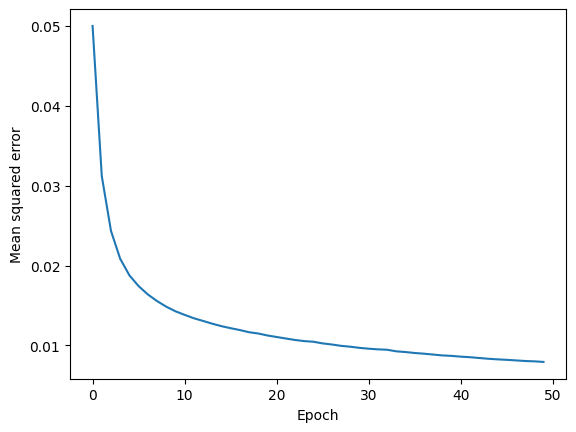

In [17]:
# MSEを50エポックでプロット
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show()

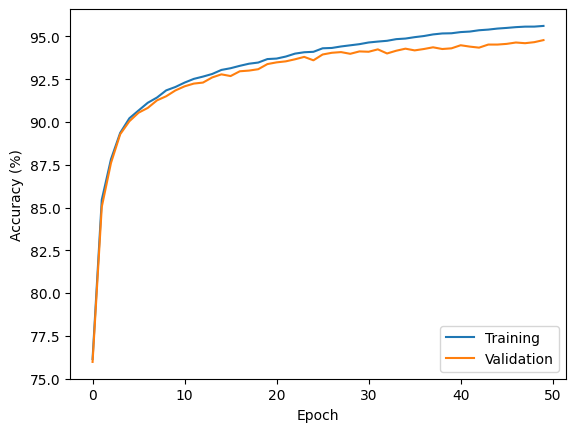

In [18]:
# 訓練データと検証データの正解率を50エポックでプロット
plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc, label='Validation')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

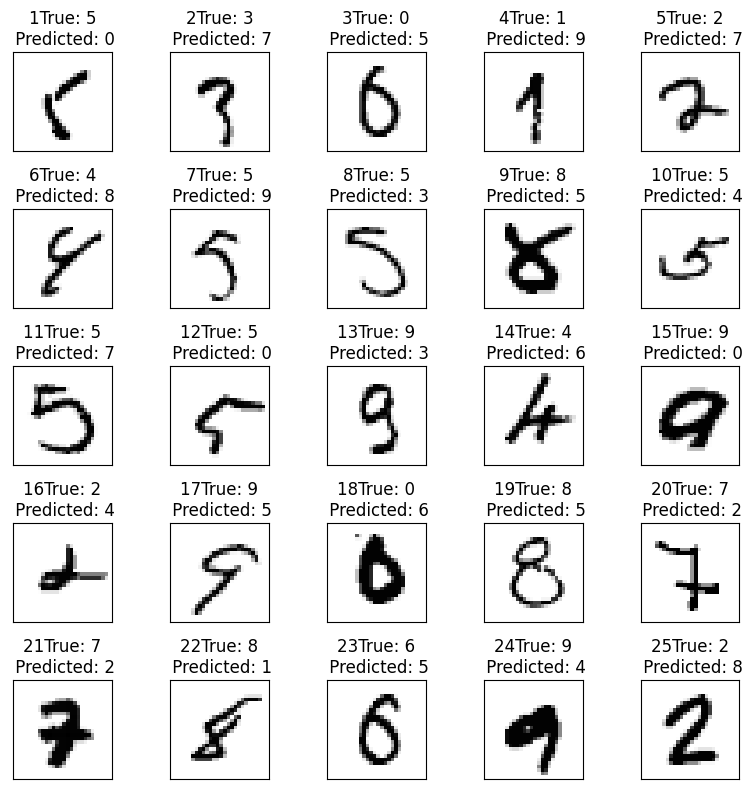

In [20]:
# 誤分類したデータの最初の25個を取り出す
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]
_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)
misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()

for i in range(25):
  img = misclassified_images[i].reshape(28, 28)
  ax[i].imshow(img, cmap='Greys', interpolation='nearest')
  ax[i].set_title(f'{i+1}'
                  f'True: {correct_labels[i]}\n'
                  f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])

plt.tight_layout()
plt.show()